In [2]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
from glob import glob
from functools import partial
from types import SimpleNamespace
import functools
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from typing import Union

from preproc import process_message_files, process_book_files
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER
import time

from jax.nn import one_hot
import torch
from tqdm.notebook import tqdm

from encoding import Message_Tokenizer, Vocab

In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
%load_ext snakeviz

In [16]:
# data_dir = '/nfs/home/peern/LOBS5/data/raw/'
data_dir = '/nfs/home/peern/LOBS5/data/raw_new/'
save_dir = '/nfs/home/peern/LOBS5/data/'

In [19]:
# example loading

message_files = sorted(glob(data_dir + '*message*.csv'))
book_files = sorted(glob(data_dir + '*orderbook*.csv'))

m = pd.read_csv(
    message_files[0],
    names=['time', 'event_type', 'order_id', 'size', 'price', 'direction'],
    index_col=False)

b = pd.read_csv(
    book_files[0],
    index_col=False,
    header=None
)

/nfs/home/peern/rlenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [99]:
#b_proc = np.load('/nfs/home/peern/LOBS5/data/test/GOOG_2022-07-01_34200000_57600000_orderbook_10_proc.npy')
b_proc = np.load('/nfs/home/peern/LOBS5/data/test/GOOG_2023-01-04_34200000_57600000_orderbook_10_proc.npy')


In [100]:
b_proc.shape

(3179086, 1001)

In [101]:
b_proc = pd.DataFrame(b_proc)

In [102]:
b_proc.iloc[100000]

0       0
1       0
2       0
3       0
4       0
       ..
996     0
997     0
998     0
999     0
1000    0
Name: 100000, Length: 1001, dtype: int64

<AxesSubplot:>

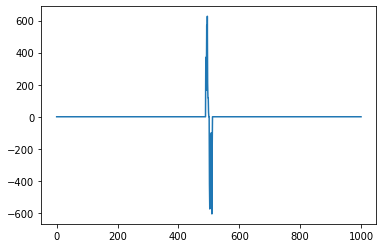

In [103]:
b_proc.iloc[100000].plot()

In [86]:
b_proc.loc[b_proc.iloc[:, 1:].sum(axis=1) > 0]

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
b_proc

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

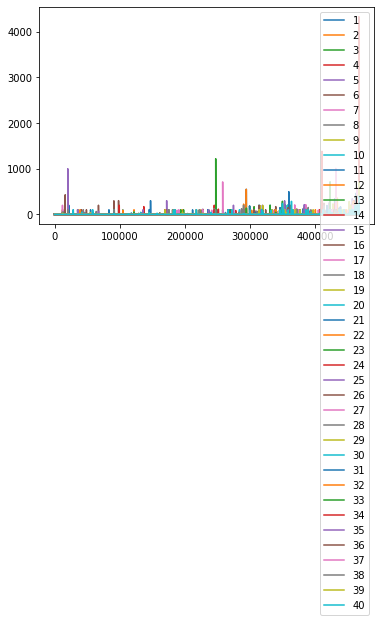

In [61]:
b_proc.iloc[:,1:].plot()

<AxesSubplot:>

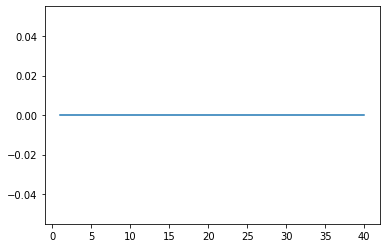

In [53]:
b_proc.iloc[1000,1:].plot()

In [24]:
book_files

['/nfs/home/peern/LOBS5/data/raw_new/GOOG_2022-07-01_34200000_57600000_orderbook_10.csv']

In [22]:
m.iloc[0]

time          3.420000e+04
event_type    1.000000e+00
order_id      3.643425e+07
size          9.100000e+01
price         2.170310e+07
direction    -1.000000e+00
Name: 0, dtype: float64

In [37]:
((b.iloc[:,0] + b.iloc[:,2]) / 2).round(-2).astype(int)

0         21686500.0
1         21686500.0
2         21686500.0
3         21686500.0
4         21686500.0
             ...    
477400    21811800.0
477401    21811800.0
477402    21811800.0
477403    21811800.0
477404    21811800.0
Length: 477405, dtype: float64

<AxesSubplot:>

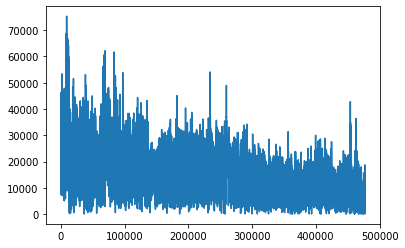

In [28]:
(b.iloc[:,0] - b.iloc[:,2]).plot()

<AxesSubplot:>

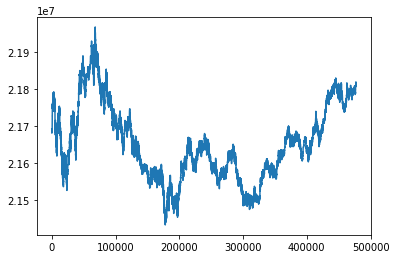

In [6]:
b.iloc[:, 0].plot()

In [17]:
2.19e7 - 915000

20985000.0

<AxesSubplot:>

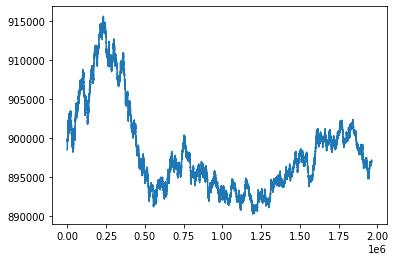

In [15]:
b.iloc[:, 0].plot()

<AxesSubplot:>

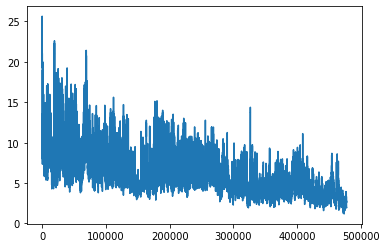

In [30]:
(b.iloc[:, -4] - b.iloc[:, -2]).div(10000).plot()

<AxesSubplot:>

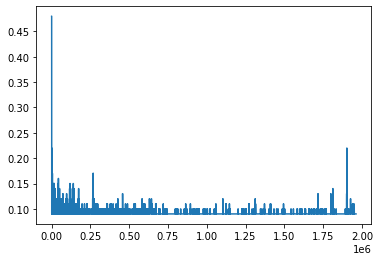

In [16]:
(b.iloc[:, -4] - b.iloc[:, 0]).div(10000).plot()

<AxesSubplot:>

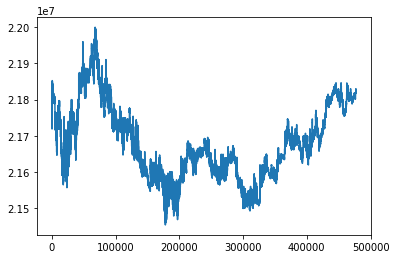

In [9]:
b.iloc[:, -4].plot()

## Encoding

In [12]:
message_files = sorted(glob(data_dir + '*message*.csv'))
book_files = sorted(glob(data_dir + '*orderbook*.csv'))

In [13]:
message_files

['/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-03_34200000_57600000_message_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-04_34200000_57600000_message_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-05_34200000_57600000_message_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-06_34200000_57600000_message_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-09_34200000_57600000_message_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-10_34200000_57600000_message_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-30_34200000_57600000_message_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-31_34200000_57600000_message_10.csv']

In [14]:
book_files

['/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-03_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-04_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-05_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-06_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-09_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-10_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-30_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-31_34200000_57600000_orderbook_10.csv']

In [27]:
# filter down from 10 to 2 levels, preprocess, encode and save to file (.npy)

data_dir = '/nfs/home/peern/LOBS5/data/raw/'
save_dir = '/nfs/home/peern/LOBS5/data/l2/'

process_message_files(message_files, book_files, save_dir, filter_above_lvl=2)

0it [00:00, ?it/s]

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-03_34200000_57600000_message_10.csv
<< pre processing >>
truncating 0.0000% of prices > 9900
truncating 0.0000% of prices < -9900
<< encoding >>
saved to /nfs/home/peern/LOBS5/data/l2/GOOG_2023-01-03_34200000_57600000_message_10_proc.npy


In [33]:
process_book_files(
    message_files,
    book_files,
    save_dir,
    filter_above_lvl=2,  # 2 best price levels
    n_price_series=8  # represented by an 8-tick range
)

0it [00:00, ?it/s]

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-03_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-03_34200000_57600000_orderbook_10.csv


/tmp/ipykernel_574720/1788490804.py:1: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  process_book_files(
/nfs/home/peern/rlenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-04_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-04_34200000_57600000_orderbook_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-05_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-05_34200000_57600000_orderbook_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-06_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-06_34200000_57600000_orderbook_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-09_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-09_34200000_57600000_orderbook_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-10_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-10_34200000_57600000_orderbook_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-30_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-30_34200000_57600000_orderbook_10.csv
/nfs/home/peern/LOBS5/data/r

In [37]:
message_files

[]

In [43]:
# check all file lengths match

message_files = sorted(glob(save_dir + '*message*.npy'))
book_files = sorted(glob(save_dir + '*orderbook*.npy'))

for m_f, b_f in tqdm(zip(message_files, book_files)):
    # don't load whole file into memory
    m = np.load(m_f, mmap_mode='r')
    b = np.load(b_f, mmap_mode='r')
    print('n_samples', m.shape[0] + 1, b.shape[0])
    assert (m.shape[0] + 1) == b.shape[0], f'{m.shape[0]} != {b.shape[0]}'

0it [00:00, ?it/s]

n_samples 915496 915496
n_samples 1464402 1464402
n_samples 1148874 1148874
n_samples 1267564 1267564
n_samples 1138789 1138789
n_samples 1353753 1353753
n_samples 1299194 1299194
n_samples 1089204 1089204


In [8]:
#import warnings

#def my_formatwarning(message, category, filename, lineno, line=None):
#    print(message, category)
    # lineno is the line number you are looking for
#    print('file:', filename, 'line number:', lineno) 

#warnings.formatwarning = my_formatwarning

## DataLoader

In [8]:
test_dir = '/nfs/home/peern/LOBS5/data/test/'

In [17]:
messages = sorted(glob(save_dir + '*message*.npy'))
messages

['/nfs/home/peern/LOBS5/data/GOOG_2023-01-03_34200000_57600000_message_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-04_34200000_57600000_message_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-05_34200000_57600000_message_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-06_34200000_57600000_message_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-09_34200000_57600000_message_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-10_34200000_57600000_message_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-30_34200000_57600000_message_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-31_34200000_57600000_message_10_proc.npy']

In [18]:
books = sorted(glob(save_dir + '*book*.npy'))
books

['/nfs/home/peern/LOBS5/data/GOOG_2023-01-03_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-04_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-05_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-06_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-09_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-10_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-30_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-31_34200000_57600000_orderbook_10_proc.npy']

In [26]:
#%%snakeviz -t

d = LOBSTER_Dataset(
    message_files=messages,
    book_files=books,
    n_messages=500,
    n_cache_files=0,
    mask_fn=LOBSTER_Dataset.random_mask,
    randomize_offset=True,
    seed=42
)

d[900]

(memmap([  4, 983, 550, ...,   2,   2,   2]),
 array([2]),
 memmap([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]))

In [7]:
len(d)

37627

In [8]:
d.seq_offsets

{0: 44, 1: 386, 2: 327, 3: 219, 4: 216, 5: 429, 6: 42, 7: 348}

In [11]:
d[0][0]#.shape

array([  3,   3, 201, ...,   2,   2,   2])

In [228]:
sub = LOBSTER_Subset(d, [2, 3, 7, 7000, 7001, 7002, 7003])

In [229]:
ls = LOBSTER_Sampler(sub, n_files_shuffle=1, batch_size=2, seed=42)

In [230]:
for i, e in enumerate(ls):
    print(e)
    if i > 20:
        break

[7002, 7000]
[7003, 7001]
[2, 7]


In [6]:
message_files

['/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-30_34200000_57600000_message_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-31_34200000_57600000_message_10.csv']

In [96]:
dataset_obj = LOBSTER(
    'lobster',
    data_dir='/nfs/home/peern/LOBS5/data/raw/',
    mask_fn=LOBSTER_Dataset.random_mask
)
dataset_obj.setup()

In [80]:
len(dataset_obj.dataset_train)

4025

In [81]:
len(dataset_obj.dataset_test)

365

In [82]:
len(dataset_obj.dataset_val)

448

In [99]:
sampler = LOBSTER_Sampler(dataset_obj.dataset_train, n_files_shuffle=1, batch_size=16, seed=42)

In [100]:
max(dataset_obj.dataset_train.indices_on_day[0])

4024

In [106]:
for i, batch_idxs in enumerate(sampler):
    print(i)
    print(batch_idxs)
    data = dataset_obj.dataset_train[batch_idxs]
    print(len(data[0]))
    batch = jnp.array(data[0])
    print(batch.shape)
    #print('data', dataset_obj.dataset_train[i])
    #print(data)
    #print(len(data))
    #print(len(data[0]))
    #print(len(data[1]))
    break
    

0
[2708, 933, 3166, 1185, 326, 3503, 953, 3549, 413, 3973, 3981, 1857, 2603, 3416, 1494, 666]
16
(16, 10000)


In [61]:
d.seq_offsets

{0: 44, 1: 386}

In [50]:
d._get_seq_location(0)

(0, 44)

In [19]:
8131 * 500

4065500

In [17]:
d[2]

(array([  3,   4, 703, ...,   2,   2,   2]), array([11110]))

In [169]:
d = LOBSTER_Dataset(message_files=messages, n_messages=500, n_cache_files=2)

start_time = time.time()

for i in range(5000):
    d[i]

print("--- %s seconds ---" % (time.time() - start_time))

TypeError: __init__() missing 1 required positional argument: 'mask_fn'

In [358]:
d = LOBSTER_Dataset(
    message_files=messages,
    n_messages=500,
    n_cache_files=2,
    seed=42,
    mask_fn=LOBSTER_Dataset.causal_mask)


In [359]:
X, y = d[2]

In [360]:
X[-20:]

array([    3,     4,   176,   529,   920,  1006,  1091, 11108, 11007,
       11110,     2,     2,     2,     2,     2,     2,     0,     2,
           2,     2])

In [361]:
y

array([2])

In [8]:
v = Vocab()
v.ENCODING

{'time': {'000': 3,
  '001': 4,
  '002': 5,
  '003': 6,
  '004': 7,
  '005': 8,
  '006': 9,
  '007': 10,
  '008': 11,
  '009': 12,
  '010': 13,
  '011': 14,
  '012': 15,
  '013': 16,
  '014': 17,
  '015': 18,
  '016': 19,
  '017': 20,
  '018': 21,
  '019': 22,
  '020': 23,
  '021': 24,
  '022': 25,
  '023': 26,
  '024': 27,
  '025': 28,
  '026': 29,
  '027': 30,
  '028': 31,
  '029': 32,
  '030': 33,
  '031': 34,
  '032': 35,
  '033': 36,
  '034': 37,
  '035': 38,
  '036': 39,
  '037': 40,
  '038': 41,
  '039': 42,
  '040': 43,
  '041': 44,
  '042': 45,
  '043': 46,
  '044': 47,
  '045': 48,
  '046': 49,
  '047': 50,
  '048': 51,
  '049': 52,
  '050': 53,
  '051': 54,
  '052': 55,
  '053': 56,
  '054': 57,
  '055': 58,
  '056': 59,
  '057': 60,
  '058': 61,
  '059': 62,
  '060': 63,
  '061': 64,
  '062': 65,
  '063': 66,
  '064': 67,
  '065': 68,
  '066': 69,
  '067': 70,
  '068': 71,
  '069': 72,
  '070': 73,
  '071': 74,
  '072': 75,
  '073': 76,
  '074': 77,
  '075': 78,
  '076': 79

In [9]:
len(v)

11111

In [10]:
m_ = m.copy()

In [130]:
# TODO: for now ignore canc/del from previous days? --> use unknown token in original msg.

In [11]:
tok = Message_Tokenizer()

In [13]:
m_ = tok.preproc(m, b)

truncating 0.0000% of prices > 9900
truncating 0.0000% of prices < -9900


In [14]:
m_

,time,event_type,order_id,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
1,000000001095123,4.0,26617106,0100,+02,0.0,NaN,NaN,NaN,NaN,NaN
2,000000002310775,1.0,26628478,1700,-13,1.0,NaN,NaN,NaN,NaN,NaN
3,000000002364829,1.0,26628606,2300,-07,1.0,NaN,NaN,NaN,NaN,NaN
4,000000002446746,1.0,26628742,2254,-05,1.0,NaN,NaN,NaN,NaN,NaN
5,000000002469623,4.0,26617106,0207,+02,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1962415,023399985151757,1.0,905843398,6159,-01,1.0,NaN,NaN,NaN,NaN,NaN
1962416,023399985166759,1.0,905843410,6159,+07,0.0,NaN,NaN,NaN,NaN,NaN
1962417,023399985729067,1.0,905843602,9999,+03,0.0,NaN,NaN,NaN,NaN,NaN
1962418,023399986159522,1.0,905843674,4500,+04,0.0,NaN,NaN,NaN,NaN,NaN


In [21]:
mod_times = (m_.time_new.astype(float) - m_.time.astype(float)).dropna()
mod_times.describe()

count    9.347010e+05
mean     2.506914e+09
std      1.482507e+10
min      1.439000e+03
25%      2.190181e+07
50%      2.595456e+08
75%      1.295224e+09
max      2.766824e+12
dtype: float64

In [27]:
mod_times.quantile(0.90) / 1e9

4.185368577

In [27]:
m_enc = tok.encode(m_, v)

time
event_type
size
price
direction
time_new
event_type_new
size_new
price_new
direction_new


In [28]:
m_enc

array([[    3,     3,     3, ...,     2,     2,     2],
       [    3,     3,     3, ...,     2,     2,     2],
       [    3,     3,     3, ...,     2,     2,     2],
       ...,
       [   26,   402,  1000, ...,     2,     2,     2],
       [   26,   402,   999, ..., 11108, 11007, 11110],
       [   26,   402,   985, ..., 11107, 11009, 11109]])

In [29]:
m_enc.shape

(2237220, 20)

In [30]:
m_enc[:2]

array([[    3,     3,     3,   116,   282,  1006,  1207, 11107, 11008,
        11109,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2],
       [    3,     3,     3,   271,   907,  1006,  1107, 11107, 11009,
        11109,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2]])

In [31]:
tok.decode(m_enc[:4], v)

[['000' '000' '000' '113' '279' '4' '020' '+' '01' '0' 'NAN' 'NAN' 'NAN'
  'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN']
 ['000' '000' '000' '268' '904' '4' '010' '+' '02' '0' 'NAN' 'NAN' 'NAN'
  'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN']
 ['000' '000' '000' '280' '750' '1' '010' '+' '01' '0' 'NAN' 'NAN' 'NAN'
  'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN']
 ['NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN' 'NAN' '000' '000'
  '001' '138' '045' '3' '010' '-' '10' '1']]


array([[ 1.132790e+05,  4.000000e+00,  2.000000e+01,  1.000000e+00,
         0.000000e+00,           nan,           nan,           nan,
                  nan,           nan],
       [ 2.689040e+05,  4.000000e+00,  1.000000e+01,  2.000000e+00,
         0.000000e+00,           nan,           nan,           nan,
                  nan,           nan],
       [ 2.807500e+05,  1.000000e+00,  1.000000e+01,  1.000000e+00,
         0.000000e+00,           nan,           nan,           nan,
                  nan,           nan],
       [          nan,           nan,           nan,           nan,
                  nan,  1.138045e+06,  3.000000e+00,  1.000000e+01,
        -1.000000e+01,  1.000000e+00]])

In [ ]:
tok.decode(m_enc[:2], v)

array([[1.13279e+05, 4.00000e+00, 2.00000e+02, 1.00000e+00, 0.00000e+00,
                nan,         nan,         nan,         nan,         nan],
       [2.68904e+05, 4.00000e+00, 1.00000e+02, 2.00000e+00, 0.00000e+00,
                nan,         nan,         nan,         nan,         nan]])

In [62]:
m.loc[m.event_type < 5].iloc[1:3]

,time,event_type,order_id,size,price,direction
1,34200.000113,4,25053166,200,987500,-1
6,34200.000269,4,24918322,100,987600,-1


In [64]:
len(m)

2244841

In [70]:
m.loc[m.event_type == 1].loc[m.duplicated(keep=False)]

,time,event_type,order_id,size,price,direction


In [109]:
enc = v.ENCODING['generic']
m_.time.apply(lambda num: [enc[d] for d in str(num)])

1             [8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 11, 10, 15, 17]
6            [8, 8, 8, 8, 8, 8, 8, 8, 10, 14, 16, 17, 8, 12]
7             [8, 8, 8, 8, 8, 8, 8, 8, 10, 16, 8, 15, 13, 8]
8             [8, 8, 8, 8, 8, 8, 8, 9, 9, 11, 16, 8, 12, 13]
9           [8, 8, 8, 8, 8, 8, 8, 9, 11, 15, 13, 17, 11, 17]
                                 ...                        
2244836    [10, 11, 11, 17, 17, 17, 17, 14, 13, 8, 15, 11...
2244837    [10, 11, 11, 17, 17, 17, 17, 14, 13, 12, 9, 12...
2244838    [10, 11, 11, 17, 17, 17, 17, 15, 9, 12, 15, 8,...
2244839    [10, 11, 11, 17, 17, 17, 17, 15, 13, 10, 9, 10...
2244840    [10, 11, 11, 17, 17, 17, 17, 15, 15, 14, 14, 8...
Name: time, Length: 2237220, dtype: object

### Book State Preprocessing

In [6]:
book_files = sorted(glob(data_dir + '*orderbook*.csv'))
book_files

['/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-03_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-04_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-05_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-06_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-09_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-10_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-30_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-31_34200000_57600000_orderbook_10.csv']

In [7]:
# def process_book(b, price_levels):
#     b_indices = b.iloc[:, ::2].sub(b[2], axis=0).div(100).astype(int)
#     b_indices = b_indices + price_levels // 2 - 2  # -2 to account for average spread
#     b_indices.columns = list(range(b_indices.shape[1]))
#     vol_book = b.iloc[:, 1::2]
#     vol_book.columns = list(range(vol_book.shape[1]))

#     # convert to book representation with volume at each price level relative to best bid
#     # i.e. at each time we have a fixed width snapshot around the best bid
#     # therefore movement of the mid price needs to be a separate feature (e.g. relative to previous price)

#     mybook = np.zeros((len(b), price_levels), dtype=np.int32)

#     a = b_indices.values
#     for i in range(a.shape[0]):
#         for j in range(a.shape[1]):
#             price = a[i, j]
#             if price >= 0 and price < price_levels:
#                 mybook[i, price] = vol_book.values[i, j]

#     # prepend column with best bid changes (in ticks)
#     bid_diff = b[2].div(100).diff().fillna(0).astype(int).values
#     return np.concatenate([bid_diff[:, None], mybook], axis=1)

In [8]:
book_files

['/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-03_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-04_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-05_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-06_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-09_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-10_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-30_34200000_57600000_orderbook_10.csv',
 '/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-31_34200000_57600000_orderbook_10.csv']

In [5]:
from tqdm.notebook import tqdm
from preproc import process_book

In [7]:
for m_f, b_f in tqdm(zip(message_files, book_files)):
    print(m_f)
    print(b_f)
    print()

    messages = pd.read_csv(
        m_f,
        names=['time', 'event_type', 'order_id', 'size', 'price', 'direction'],
        index_col=False)

    book = pd.read_csv(
        b_f,
        index_col=False,
        header=None
    )

    # remove diallowed order types
    messages = messages.loc[messages.event_type.isin([1, 2, 3, 4])]
    book = book.loc[messages.index]

    book = process_book(book, price_levels=40)
    b_path = save_dir + b_f.rsplit('/', maxsplit=1)[-1][:-4] + '_proc.npy'
    np.save(b_path, book, allow_pickle=True)

0it [00:00, ?it/s]

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-03_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-03_34200000_57600000_orderbook_10.csv

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-04_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-04_34200000_57600000_orderbook_10.csv

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-05_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-05_34200000_57600000_orderbook_10.csv

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-06_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-06_34200000_57600000_orderbook_10.csv

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-09_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-09_34200000_57600000_orderbook_10.csv

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-10_34200000_57600000_message_10.csv
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-10_34200000_57600000_orderbook_10.csv

/nfs/home/peern/LOBS5/

In [125]:
my_book = process_book(b, 40)

In [126]:
my_book_df = pd.DataFrame(my_book)

<AxesSubplot:>

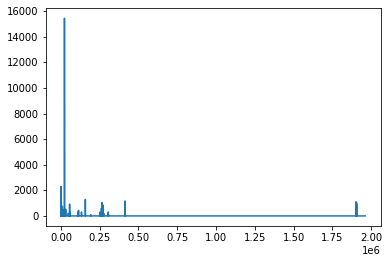

In [127]:
my_book_df.iloc[:,7].plot()

In [128]:
my_book_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,1.962420e+06,1962420.0,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,...,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06,1.962420e+06
mean,-7.134049e-06,0.0,2.104137e-02,1.816380e-02,9.918519e-02,2.238364e-01,5.072171e-01,8.497982e-01,2.636656e+00,1.388989e+01,...,5.820159e+01,1.527995e+01,4.735169e+00,1.612250e+00,4.961074e-01,2.170198e-01,1.049047e-01,8.043283e-02,3.201048e-02,3.042060e-02
std,1.683192e-01,0.0,4.517930e+00,4.309747e+00,1.096578e+01,1.461462e+01,6.657229e+01,6.008135e+01,7.422632e+01,1.492593e+02,...,2.499058e+02,1.130011e+02,6.718697e+01,3.934303e+01,1.966742e+01,1.172099e+01,9.794400e+00,1.043434e+01,2.983703e+00,2.435108e+00
min,-5.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,8.000000e+00,0.0,1.000000e+03,1.700000e+03,2.300000e+03,2.300000e+03,1.544500e+04,1.544500e+04,1.544500e+04,1.565300e+04,...,9.900000e+03,5.790000e+03,5.790000e+03,2.354000e+03,2.354000e+03,2.001000e+03,2.354000e+03,2.254000e+03,2.254000e+03,5.670000e+02


In [45]:
# prices in ticks from best bid
b_ticks = b.iloc[:, ::2].sub(b[2], axis=0).div(100).astype(int)
b_ticks

,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38
0,2,0,15,-1,19,-2,30,-3,31,-4,35,-7,37,-14,40,-15,47,-16,50,-23
1,2,0,15,-1,19,-2,30,-3,31,-4,35,-7,37,-14,40,-15,47,-16,50,-23
2,2,0,15,-1,19,-2,30,-3,31,-4,35,-7,37,-13,40,-14,47,-15,50,-16
3,2,0,15,-1,19,-2,30,-3,31,-4,35,-7,37,-13,40,-14,47,-15,50,-16
4,2,0,15,-1,19,-2,30,-3,31,-4,35,-5,37,-7,40,-13,47,-14,50,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962415,1,0,2,-1,3,-2,4,-3,5,-4,6,-5,7,-6,8,-7,9,-8,10,-9
1962416,1,0,2,-1,3,-2,4,-3,5,-4,6,-5,7,-6,8,-7,9,-8,10,-9
1962417,1,0,2,-1,3,-2,4,-3,5,-4,6,-5,7,-6,8,-7,9,-8,10,-9
1962418,1,0,2,-1,3,-2,4,-3,5,-4,6,-5,7,-6,8,-7,9,-8,10,-9


In [67]:
price_levels = 40
b_indices = b_ticks + price_levels // 2 - 2  # -2 to account for average spread
b_indices.columns = list(range(b_indices.shape[1]))
b_indices

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,20,18,33,17,37,16,48,15,49,14,53,11,55,4,58,3,65,2,68,-5
1,20,18,33,17,37,16,48,15,49,14,53,11,55,4,58,3,65,2,68,-5
2,20,18,33,17,37,16,48,15,49,14,53,11,55,5,58,4,65,3,68,2
3,20,18,33,17,37,16,48,15,49,14,53,11,55,5,58,4,65,3,68,2
4,20,18,33,17,37,16,48,15,49,14,53,13,55,11,58,5,65,4,68,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962415,19,18,20,17,21,16,22,15,23,14,24,13,25,12,26,11,27,10,28,9
1962416,19,18,20,17,21,16,22,15,23,14,24,13,25,12,26,11,27,10,28,9
1962417,19,18,20,17,21,16,22,15,23,14,24,13,25,12,26,11,27,10,28,9
1962418,19,18,20,17,21,16,22,15,23,14,24,13,25,12,26,11,27,10,28,9


In [68]:
vol_book = b.iloc[:, 1::2]
vol_book.columns = list(range(vol_book.shape[1]))
vol_book

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,307,355,6,2353,22,2817,100,25,200,47,66,400,1,200,100,300,1,200,1300,2
1,207,355,6,2353,22,2817,100,25,200,47,66,400,1,200,100,300,1,200,1300,2
2,207,355,6,2353,22,2817,100,25,200,47,66,400,1,1700,100,200,1,300,1300,200
3,207,355,6,2353,22,2817,100,25,200,47,66,2700,1,1700,100,200,1,300,1300,200
4,207,355,6,2353,22,2817,100,25,200,47,66,2254,1,2700,100,1700,1,200,1300,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962415,21111,46306,7386,47191,7425,61526,12504,2700,16598,700,13500,11000,8414,2177,4310,600,9702,16800,15800,200
1962416,21111,46306,7386,47191,7425,61526,12504,2700,16598,700,13500,11000,14573,2177,4310,600,9702,16800,15800,200
1962417,21111,46306,7386,47191,19025,61526,12504,2700,16598,700,13500,11000,14573,2177,4310,600,9702,16800,15800,200
1962418,21111,46306,7386,47191,19025,61526,17004,2700,16598,700,13500,11000,14573,2177,4310,600,9702,16800,15800,200


In [80]:
vol_book.iloc[1000]

0      751
1       50
2     4057
3      100
4      200
5      122
6       25
7      100
8      100
9      118
10      25
11     285
12      25
13     122
14     200
15     110
16      25
17    1005
18       1
19    1355
Name: 1000, dtype: int64

In [69]:
price_levels = 40
mybook = np.zeros((len(b), price_levels))

In [72]:
# convert to book representation with volume at each price level relative to best bid
# i.e. at each time we have a fixed width snapshot around the best bid
# therefore movement of the mid price needs to be a separate feature (e.g. relative to previous price)

price_levels = 40
mybook = np.zeros((len(b), price_levels), dtype=np.int32)

a = b_indices.values
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        price = a[i, j]
        if price >= 0 and price < price_levels:
            mybook[i, price] = vol_book.values[i, j]

In [85]:
mybook

array([[  0.,   0., 200., ...,  22.,   0.,   0.],
       [  0.,   0., 200., ...,  22.,   0.,   0.],
       [  0.,   0., 200., ...,  22.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [92]:
bid_diff = b[2].div(100).diff().fillna(0).astype(int).values
bid_diff

array([0, 0, 0, ..., 0, 0, 0])

In [99]:
bid_diff = b[2].div(100).diff().fillna(0).astype(int).values
mybook_ = np.concatenate([mybook, bid_diff[:, None]], axis=1)

In [100]:
mybook_.shape

(1962420, 41)

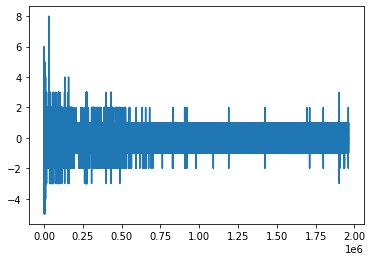

In [95]:
import matplotlib.pyplot as plt
plt.plot(bid_diff)

## Decoding

In [ ]:
toks = np.copy(m_enc[111:113])
toks

NameError: name 'm_enc' is not defined

In [ ]:
toks[0,13] = -1
toks[0,-1] = -1
toks

array([[ 9,  9,  9,  9,  9, 12, 12, 10, 13, 11, 11, 15,  9, -1,  3,  9,
        10,  9,  9, 20,  9, 18,  8,  9,  9,  9,  9,  9, 13,  9, 18, 14,
        16, 12, 11,  9, 18,  5,  9, 10,  9,  9, 20,  9, 18, -1],
       [ 9,  9,  9,  9,  9, 13, 10,  9,  9, 10,  9, 15, 15, 10,  6,  9,
         9, 12, 15, 19,  9, 15,  7,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]])

In [ ]:
valid, idx = tok._validate_syntax(toks, v)

In [ ]:
tok._decode_to_str(toks, v)

NameError: name 'toks' is not defined

## DEPRECATED (lossy encoding)

In [ ]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def relabel_series(s, allowed_labels=None):
    if allowed_labels is None:
        allowed_labels = sorted(s.unique())
    label_map = {orig: i for i, orig in enumerate(allowed_labels)}
    return s.replace(label_map)

def _preproc_prices(p, bb, p_lower_trunc=-1000, p_upper_trunc=1300):
    """ Takes prices series and best bid, encoding prices relative to best bid.
        Returns scaled price series
    """
    # encode prices relative to (previous) best bid
    p = p - bb
    # truncate price at deviation of 1000
    # min tick is 100, hence min 10-level diff is 900
    # <= 1000 covers ~99.54% on bid side, ~99.1% on ask size (GOOG)
    pct_changed = 100 * len(p.loc[p > p_upper_trunc]) / len(p)
    print(f"truncating {pct_changed:.4f}% of prices > {p_upper_trunc}")
    p.loc[p > p_upper_trunc] = p_upper_trunc
    pct_changed = 100 * len(p.loc[p < p_lower_trunc]) / len(p)
    print(f"truncating {pct_changed:.4f}% of prices < {p_lower_trunc}")
    p.loc[p < p_lower_trunc] = p_lower_trunc
    # scale prices to min ticks size differences
    p /= 100
    return p

# TODO: write function which calculates bins on selection of training data
#       and writes thresholds and medians to config file for future processing

def quantize_time(time, n_categories, t_bins=None):
    """ quantize Dt based on quantiles
        Dt = 0 is set as one fixed category using code 0
    """
    if t_bins is not None:
        assert len(t_bins) == n_categories-2 or n_categories is None

    delta_t = time.diff()
    # log transformation actually not necessary if binned by quantiles
    # but useful for other binning methods (e.g. equal bin size)
    #ln_delta_t = np.log(delta_t)
    t_groups = delta_t.copy()
    # special category if delta t is 0 (orders come it at same time)
    t_groups.loc[delta_t == 0] = 0
    # quantize time differences (leaving out delta t = as separate category)
    # using data quantiles
    if t_bins is None:
        cats, t_bins = pd.qcut(
            delta_t.loc[delta_t > 0],
            n_categories-1,
            labels=range(1, n_categories),
            retbins=True)
    # use given bin thresholds (e.g from fixed training data)
    else:
        cats = pd.cut(delta_t.loc[delta_t > 0], bins=t_bins, labels=range(1, n_categories))

    t_groups.loc[delta_t > 0] = cats.astype(float)
    # median Dt value per bin: can use this value for decoding
    bin_medians = delta_t.groupby(t_groups).median()
    return t_groups, t_bins, bin_medians

def pre_proc_lobster(
        m,
        b,
        n_time_bins=20,
        t_bins=None,
        size_bins=None,
        p_lower_trunc=-1000,
        p_upper_trunc=1300,
        allowed_event_types=[1,2,3,4],
        one_hot_enc=True
    ):
    # filter out only allowed event types ...
    m = m.loc[m.event_type.isin(allowed_event_types)].copy()
    # ... and corresponding book changes
    b = b.loc[m.index]
    
    # group sizes by given bins
    if size_bins is not None:
        _take_closest = functools.partial(take_closest, size_bins)
        m['size'] = m['size'].apply(_take_closest)

    # round prices to given decimal (-1 for 10 ticks)
    #m['price'] = np.around(m['price'], price_round_to)

    # (previous) best bid
    bb = book.iloc[:, 2].shift()
    m['price'] = _preproc_prices(m['price'], bb, p_lower_trunc, p_upper_trunc)

    # TODO: save t_bins, bin_medians
    # quantize time deltas
    m['dt'], t_bins, bin_medians = quantize_time(m.time, n_time_bins, t_bins=t_bins)
    # scale time of day using min/max (0,1)
    opening_s = 9.5 * 3600  # NASDAQ opens 9:30
    closing_s = 16 * 3600   # and closes at 16:00
    df['time'] = (df['time'] - opening_s) / (closing_s - opening_s)

    # remove first row
    m = m.iloc[1:]
    b = b.iloc[1:]

    # encode features
    #m['event_type'], _ = encode_feature(m['event_type'], allowed_event_types, one_hot=one_hot_enc)
    #m['direction'], _ = encode_feature(m['size'], [-1, 1], one_hot=one_hot_enc)
    #m['size'], _ = encode_feature(m['size'], sorted(m['size'].unique()), one_hot=one_hot_enc)
    #m['price'], _ = encode_feature(m['price'], sorted(m['price'].unique()), one_hot=one_hot_enc)
    m['time'] = m['time']  #
    m['event_type'] = relabel_series(m['event_type'], allowed_event_types)
    m['direction'] = relabel_series(m['direction'], [-1, 1])
    m['size'] = relabel_series(m['size'])
    m['price'] = relabel_series(m['price'])

    return m, b

_='''
def _encode_feature(
        s: pd.Series, 
        categories: Union[str, list] = 'auto',
        one_hot: bool = True  # one_hot or ordinal
    ):
    if one_hot:
        enc = OneHotEncoder(categories=[categories])
    else:
        enc = OrdinalEncoder(categories=[categories])
    s = s.values.reshape((-1,1))
    enc = enc.fit(s)
    return enc.transform(s), enc
'''

In [ ]:
size_bins = list(range(1,50,1))
size_bins.extend(list(range(50,100,5)))
size_bins.extend(list(range(100,501,100)))

assert len(message_files) == len(book_files)
for m_f, b_f in zip(message_files, book_files):
    print(m_f)
    messages = pd.read_csv(
        m_f,
        names=['time', 'event_type', 'order_id', 'size', 'price', 'direction'],
        index_col=False)

    book = pd.read_csv(
        b_f,
        index_col=False,
        header=None
    )

    m_, b_ = pre_proc_lobster(messages, book, size_bins, allowed_event_types=[1,4])

    # save processed message and book
    m_path = save_dir + m_f.rsplit('/', maxsplit=1)[-1][:-4] + '_proc.csv'
    b_path = save_dir + b_f.rsplit('/', maxsplit=1)[-1][:-4] + '_proc.csv'
    m_.to_csv(m_path, index=False, header=False)
    b_.to_csv(b_path, index=False, header=False)

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-30_34200000_57600000_message_10.csv


/nfs/home/peern/rlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nfs/home/peern/rlenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


truncating 0.0043% of prices > 1300
truncating 0.0038% of prices < -1000
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-31_34200000_57600000_message_10.csv
truncating 0.0046% of prices > 1300
truncating 0.0013% of prices < -1000


In [ ]:
m

,time,event_type,order_id,size,price,direction
0,34200.000113,4,24695958,134,987500,-1
1,34200.000113,4,25053166,200,987500,-1
2,34200.000113,5,0,200,987500,1
3,34200.000135,5,0,600,987500,1
4,34200.000163,5,0,100,987500,1
...,...,...,...,...,...,...
2244836,57599.996507,1,770732874,1385,979600,1
2244837,57599.996541,1,770732886,1,979600,1
2244838,57599.997147,1,770733066,3500,978700,1
2244839,57599.997521,3,770732874,1385,979600,1


In [ ]:
b

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,987500,200,987400,16298,987600,200,986900,138,987900,600,...,985900,350,989600,200,985800,1,989900,500,985600,66
1,987600,200,987400,16298,987900,600,986900,138,988300,100,...,985900,350,989900,500,985800,1,991000,1,985600,66
2,987600,200,987400,16298,987900,600,986900,138,988300,100,...,985900,350,989900,500,985800,1,991000,1,985600,66
3,987600,200,987400,16298,987900,600,986900,138,988300,100,...,985900,350,989900,500,985800,1,991000,1,985600,66
4,987600,200,987400,16298,987900,600,986900,138,988300,100,...,985900,350,989900,500,985800,1,991000,1,985600,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244836,979800,8000,979600,6565,979900,4319,979500,47287,980000,6048,...,978900,8095,980600,300,978800,10650,980700,5400,978700,2300
2244837,979800,8000,979600,6566,979900,4319,979500,47287,980000,6048,...,978900,8095,980600,300,978800,10650,980700,5400,978700,2300
2244838,979800,8000,979600,6566,979900,4319,979500,47287,980000,6048,...,978900,8095,980600,300,978800,10650,980700,5400,978700,5800
2244839,979800,8000,979600,5181,979900,4319,979500,47287,980000,6048,...,978900,8095,980600,300,978800,10650,980700,5400,978700,5800


In [ ]:
m_ = m.copy()

# (previous) best bid
bb = book.iloc[:, 2].shift()
# no truncation (large thresh.)
m_.price = _preproc_prices(m.price, bb, p_lower_trunc=-9900, p_upper_trunc=9900)
m_ = m_.dropna()
m_.price = m_.price.astype(int)

truncating 0.0000% of prices > 13000
truncating 0.0000% of prices < -10000


In [ ]:
m_

,time,event_type,order_id,size,price,direction
1,34200.000113,4,25053166,200,1,-1
2,34200.000113,5,0,200,1,1
3,34200.000135,5,0,600,1,1
4,34200.000163,5,0,100,1,1
5,34200.000269,5,0,100,1,1
...,...,...,...,...,...,...
2244836,57599.996507,1,770732874,1385,0,1
2244837,57599.996541,1,770732886,1,0,1
2244838,57599.997147,1,770733066,3500,-9,1
2244839,57599.997521,3,770732874,1385,0,1


In [ ]:
m_['time'].describe()

count    2.244840e+06
mean     4.406932e+04
std      7.189496e+03
min      3.420000e+04
25%      3.755352e+04
50%      4.290529e+04
75%      4.999515e+04
max      5.760000e+04
Name: time, dtype: float64

In [ ]:
# subtract opening time and convert to ns integer
opening_s = 9.5 * 3600  # NASDAQ opens 9:30
#closing_s = 16 * 3600   # and closes at 16:00
m_['time'] = (m['time'] - opening_s).multiply(1e9).astype(int)

In [ ]:
m_.time#.multiply(1e6)#.apply(float.is_integer).all()

1              0.000113
2              0.000113
3              0.000135
4              0.000163
5              0.000269
               ...     
2244836    23399.996507
2244837    23399.996541
2244838    23399.997147
2244839    23399.997521
2244840    23399.997766
Name: time, Length: 2244840, dtype: float64

In [ ]:
m_.time

1          1.132790e+05
2          1.132790e+05
3          1.345560e+05
4          1.634550e+05
5          2.689040e+05
               ...     
2244836    2.340000e+13
2244837    2.340000e+13
2244838    2.340000e+13
2244839    2.340000e+13
2244840    2.340000e+13
Name: time, Length: 2244840, dtype: float64

## Investigate Data

In [ ]:
m_.loc[(m_.event_type_new == 3) & (m_.size_new != m_['size'])]

,time,event_type,order_id,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
8,NaN,NaN,25048950,NaN,NaN,NaN,00000001138045,3.0,0100,+986400,1.0
9,NaN,NaN,25058938,NaN,NaN,NaN,00000001375939,3.0,0100,+986400,1.0
10,NaN,NaN,24918322,NaN,NaN,NaN,00000001636989,3.0,0100,+987600,0.0
22,NaN,NaN,24912546,NaN,NaN,NaN,00000010627437,3.0,0100,+987900,0.0
25,NaN,NaN,24625822,NaN,NaN,NaN,00000012798717,3.0,0100,+988300,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2244486,23399257095943,1.0,770641814,0200,+979000,1.0,23399400871739,3.0,0100,+979000,1.0
2244566,23384544022892,1.0,768876806,0200,+978500,1.0,23399500712247,3.0,0100,+978500,1.0
2244571,23399412072736,1.0,770657050,0200,+979000,1.0,23399504733841,3.0,0100,+979000,1.0
2244664,23399602806328,1.0,770684590,0200,+979800,0.0,23399665368374,3.0,0100,+979800,0.0


In [ ]:
m_.loc[m_.order_id == 770684590]

,time,event_type,order_id,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
2244645,23399602806328,1.0,770684590,0200,+979800,0.0,NaN,NaN,NaN,NaN,NaN
2244654,23399602806328,1.0,770684590,0200,+979800,0.0,23399641629215,2.0,0100,+979800,0.0
2244664,23399602806328,1.0,770684590,0200,+979800,0.0,23399665368374,3.0,0100,+979800,0.0


In [295]:
m_['price'].value_counts().sort_index()

0.0        105
1.0      13706
2.0       9152
3.0      15134
4.0      21622
5.0      28293
6.0      34845
7.0      26895
8.0      40070
9.0      57480
10.0    195918
11.0    176574
12.0    110898
13.0     60406
14.0     35032
15.0     31865
16.0     23512
17.0     21372
18.0     12993
19.0     11104
20.0      9970
21.0      6183
22.0       410
23.0       210
Name: price, dtype: int64

In [213]:
df_.price.value_counts().sort_index()

-10.0       209
-9.0      23289
-8.0      12126
-7.0      13809
-6.0      29999
-5.0      51072
-4.0      48074
-3.0      47813
-2.0      57652
-1.0      74236
 0.0     245298
 1.0     190922
 2.0     128258
 3.0      49788
 4.0      31958
 5.0      33535
 6.0      32617
 7.0      20158
 8.0      25511
 9.0      10139
 10.0      9876
 11.0     11180
 12.0       251
 13.0       174
Name: price, dtype: int64

<AxesSubplot:>

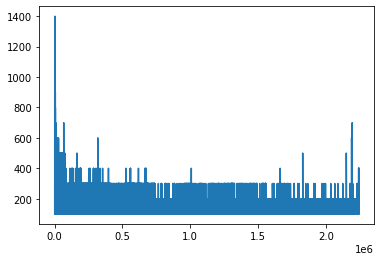

In [167]:
# what's the approx spread
(book.iloc[:, 0] - book.iloc[:, 2]).plot()

<AxesSubplot:ylabel='Frequency'>

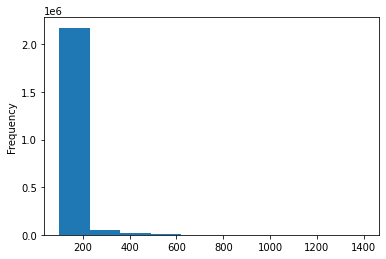

In [169]:
(book.iloc[:, 0] - book.iloc[:, 2]).plot(kind='hist')

In [165]:
# bid side: best - L10
# min tick is 100, hence min 9-level diff is 900
# <= 1000 covers 99.54%

ten_level_diff = (book.iloc[:, 2] - book.iloc[:, -2])
len(ten_level_diff.loc[ten_level_diff <= 1000]) / len(ten_level_diff)

0.9954228384103818

In [180]:
# ask side: L10 - best BID (i.e. including spread)
# min tick is 100, hence min 10-level diff is 1000
# <= 1100 covers 95.85% on ask side
# <= 1400 covers 99.49% on ask side --> use

ten_level_diff = (book.iloc[:, 2] - book.iloc[:, -4])
len(ten_level_diff.loc[ten_level_diff >= -1400]) / len(ten_level_diff)

0.9949025342997566

<AxesSubplot:ylabel='Frequency'>

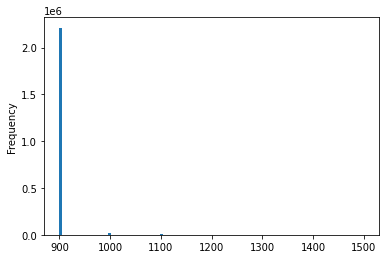

In [147]:
# what's the approx price difference between 10 levels
(book.iloc[10000:, 2] - book.iloc[10000:, -2]).plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

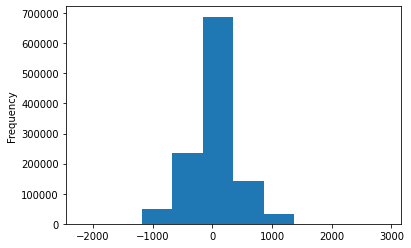

In [129]:
df_.price.plot(kind='hist')

In [104]:
normalize_messages(df_)

,time,event_type,order_id,size,price,direction
1,34200.005721,0,31920154,0,0,0
2,34200.005789,0,31920330,1,1,1
3,34200.006397,0,31921510,1,2,0
5,34200.006966,0,31922478,2,0,0
6,34200.009470,0,31926114,3,3,0
...,...,...,...,...,...,...
1836147,57599.994821,0,727635970,1,219,0
1836148,57599.994850,0,727635974,1,219,0
1836150,57599.994852,0,727635978,1,219,0
1836151,57599.997158,0,727636550,1,219,0


In [ ]:
# size <= 500 rough 99% of data
#      <= 100 85% of orders
# propose encoding: every size until 50, bin 5 until 100, then round to every x100

# price: ultimately, encode relative to mid-price at the time (not available in messages only)
#        for now, just scale absolute price, and bin 10 ticks in distr.

# order id: ignore for now

order types: start with 1, 4, i.e. ignore referential orders (cancel, delete) and hidden

1: Submission of a new limit order

2: Cancellation (partial deletion of a limit order)

3: Deletion (total deletion of a limit order)

4: Execution of a visible limit order

5: Execution of a hidden limit order

6: Indicates a cross trade, e.g. auction trade

7: Trading halt indicator (detailed information below)

In [42]:
window_size = 500
max_deviations = df.price.rolling(window=window_size).apply(lambda seg: (seg - seg.iloc[0]).max())

In [52]:
window_size = 5000
max_deviations_long = df.price.rolling(window=window_size).apply(lambda seg: (seg - seg.iloc[0]).max())

<AxesSubplot:ylabel='Frequency'>

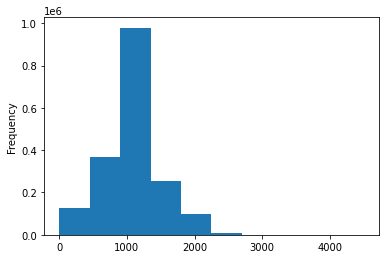

In [48]:
max_deviations.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

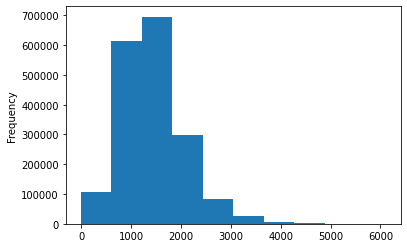

In [53]:
max_deviations_long.plot(kind='hist')

In [39]:
df['price'].describe()

count    1.836155e+06
mean     9.885920e+05
std      4.166003e+03
min      9.769000e+05
25%      9.861000e+05
50%      9.880000e+05
75%      9.905000e+05
max      1.000000e+06
Name: price, dtype: float64

<AxesSubplot:>

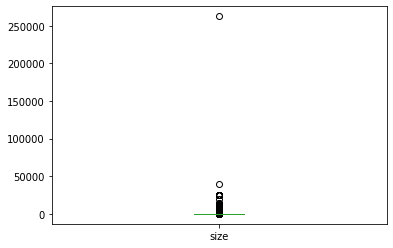

In [19]:
df['size'].plot(kind='box')

In [66]:
len(m.loc[m['size'] <= 10000]) / len(m)

0.9999937634781261

In [ ]:
len(df.loc[df['size'] <= 100]) / len(df)

0.8534208713316687

<AxesSubplot:>

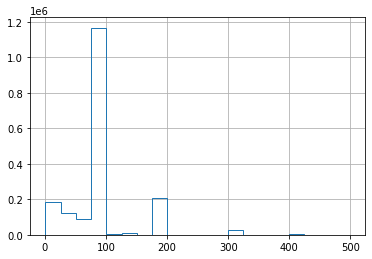

In [31]:
df.loc[df['size'] < 500, 'size'].hist(histtype='step', bins=20)

<AxesSubplot:>

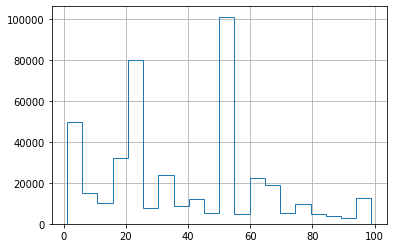

In [38]:
df.loc[df['size'] < 100, 'size'].hist(histtype='step', bins=20)

In [5]:
from lobster_dataloader import LOBSTER_Dataset
import time

In [7]:
messages = sorted(glob(save_dir + '*message*.csv'))

In [8]:
messages

['/nfs/home/peern/LOBS5/data/GOOG_2023-01-30_34200000_57600000_message_10_proc.csv',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-31_34200000_57600000_message_10_proc.csv']

In [16]:
d = LOBSTER_Dataset(message_files=messages, seq_len=500, n_cache_files=0)

start_time = time.time()

for i in range(5000):
    d[i]

print("--- %s seconds ---" % (time.time() - start_time))

--- 9.81752634048462 seconds ---


In [17]:
d = LOBSTER_Dataset(message_files=messages, seq_len=500, n_cache_files=2)

start_time = time.time()

for i in range(5000):
    d[i]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8904905319213867 seconds ---


In [331]:
d[1000]

Array([[3.4203109e+04, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.4203113e+04, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.4203133e+04, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       ...,
       [3.4205500e+04, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [3.4205500e+04, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [3.4205500e+04, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [8]:
@partial(np.vectorize, signature="(c),()->()")
def cross_entropy_loss(logits, label):
    one_hot_label = jax.nn.one_hot(label, num_classes=logits.shape[0])
    return -np.sum(one_hot_label * logits)

In [13]:
def cross_entropy_loss_(logits, label):
    #one_hot_label = jax.nn.one_hot(label, num_classes=logits.shape[0])
    return -np.sum(label * logits)

In [9]:
logits = jnp.zeros((500,91))
batch_labels = jnp.zeros((500,91))

In [14]:
cross_entropy_loss_(logits, batch_labels)

Array(-0., dtype=float32)

In [15]:
output_dims = (2,64,25)

In [19]:
cs = np.cumsum(output_dims)
np.split(test, cs[:-1], axis=1)

In [23]:
cs

array([ 2, 66, 91])

In [18]:
test = np.zeros((500, 91))

In [40]:
res = np.split(test, cs[:-1], axis=1)

In [45]:
res[0].shape

(500, 2)

In [6]:
df

,time,event_type,order_id,size,price,direction
0,34200.000113,4,24695958,134,987500,-1
1,34200.000113,4,25053166,200,987500,-1
2,34200.000113,5,0,200,987500,1
3,34200.000135,5,0,600,987500,1
4,34200.000163,5,0,100,987500,1
...,...,...,...,...,...,...
2244836,57599.996507,1,770732874,1385,979600,1
2244837,57599.996541,1,770732886,1,979600,1
2244838,57599.997147,1,770733066,3500,978700,1
2244839,57599.997521,3,770732874,1385,979600,1


In [12]:
df.loc[df.event_type == 4]

,time,event_type,order_id,size,price,direction
0,34200.000113,4,24695958,134,987500,-1
1,34200.000113,4,25053166,200,987500,-1
6,34200.000269,4,24918322,100,987600,-1
11,34200.001950,4,25058290,900,987400,1
12,34200.002162,4,25069526,100,987500,-1
...,...,...,...,...,...,...
2244813,57599.977329,4,770728458,64,979600,-1
2244814,57599.977329,4,770728690,100,979600,-1
2244824,57599.983670,4,770710794,100,979500,1
2244827,57599.992375,4,770728854,100,979600,-1


In [11]:
df.event_type.value_counts().sort_index()

1    1112809
2      23634
3    1065642
4      35136
5       7619
6          1
Name: event_type, dtype: int64

In [13]:
df.loc[df.order_id == 24695958]

,time,event_type,order_id,size,price,direction
0,34200.000113,4,24695958,134,987500,-1


<AxesSubplot:ylabel='Frequency'>

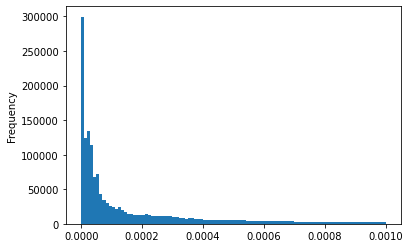

In [25]:
delta_t = df.time.diff()
delta_t.loc[delta_t < 0.001].plot(kind='hist', bins=100)

/nfs/home/peern/rlenv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:ylabel='Frequency'>

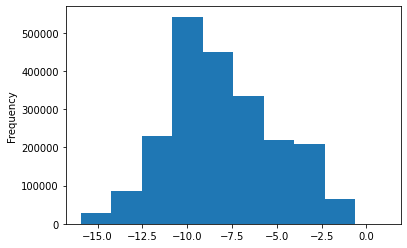

In [34]:
ln_delta_t.replace({-np.inf: np.nan, np.inf: np.nan}).dropna().plot(kind='hist', )

In [22]:
# here roughly 100 messages / s
delta_t.mean() * 500

5.211952222157259

In [74]:
# TODO: fix quantiles based on (subset of) training data

n_time_bins = 20  # one reserved for delta_t = 0
# quantiles of interest (remove 0 and 100)
q = np.linspace(0., 1., n_time_bins -1 +2)[1:-1]

delta_t = df.time.diff()
ln_delta_t = np.log(delta_t)
ln_delta_t.quantile(q=q)

/nfs/home/peern/rlenv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.05   -13.926441
0.10   -12.170320
0.15   -11.276037
0.20   -10.712674
0.25   -10.404561
0.30   -10.118266
0.35    -9.791803
0.40    -9.391831
0.45    -8.957692
0.50    -8.489133
0.55    -8.103945
0.60    -7.686760
0.65    -7.244021
0.70    -6.740778
0.75    -6.157291
0.80    -5.361655
0.85    -4.536646
0.90    -3.649945
0.95    -2.766827
Name: time, dtype: float64

In [49]:
q = np.linspace(0., 1., n_time_bins -1 +2)
q

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [60]:
ln_delta_t.loc[ln_delta_t == -np.inf]

1         -inf
2         -inf
6         -inf
18        -inf
73        -inf
          ... 
2244821   -inf
2244830   -inf
2244831   -inf
2244832   -inf
2244836   -inf
Name: time, Length: 77298, dtype: float64

In [73]:
ln_delta_t.loc[ln_delta_t > -np.inf]

1           0.000000
2           0.000000
3         -10.757884
4         -10.451704
5          -9.157283
             ...    
2244836     0.000000
2244837   -10.284748
2244838    -7.409360
2244839    -7.890701
2244840    -8.314914
Name: time, Length: 2244840, dtype: float64

In [76]:
t_groups

0                NaN
1           0.000000
2           0.000000
3         -10.757884
4         -10.451704
             ...    
2244836     0.000000
2244837   -10.284748
2244838    -7.409360
2244839    -7.890701
2244840    -8.314914
Name: time, Length: 2244841, dtype: float64

In [80]:
pd.qcut(
    ln_delta_t.loc[ln_delta_t > -np.inf],
    19,
    labels=range(1,20),
    retbins=True)

(3           4
 4           5
 5           8
 7           3
 8          13
            ..
 2244835     5
 2244837     5
 2244838    12
 2244839    11
 2244840    10
 Name: time, Length: 2167542, dtype: category
 Categories (19, int64): [1 < 2 < 3 < 4 ... 16 < 17 < 18 < 19],
 array([-15.91927773, -12.52627871, -11.47255184, -10.84018499,
        -10.47130691, -10.20205524,  -9.8453696 ,  -9.48340974,
         -9.02508977,  -8.56436341,  -8.15728677,  -7.74470355,
         -7.29653398,  -6.79604209,  -6.20015933,  -5.42619643,
         -4.57783117,  -3.67781311,  -2.78216138,   1.05717846]))

In [82]:
t_groups.loc[ln_delta_t > -np.inf]

3         -10.757884
4         -10.451704
5          -9.157283
7         -11.343520
8          -7.061728
             ...    
2244835   -10.330861
2244837   -10.284748
2244838    -7.409360
2244839    -7.890701
2244840    -8.314914
Name: time, Length: 2167542, dtype: float64

In [85]:
cats.astype(float)

3           4.0
4           5.0
5           8.0
7           3.0
8          13.0
           ... 
2244835     5.0
2244837     5.0
2244838    12.0
2244839    11.0
2244840    10.0
Name: time, Length: 2167542, dtype: float64

In [94]:
t_groups = ln_delta_t.copy()
# special category if delta t is 0 (orders come it at same time)
t_groups.loc[ln_delta_t == -np.inf] = 0
# quantize time differences (leaving out delta t = as separate category)
cats, t_bins = pd.qcut(
    ln_delta_t.loc[ln_delta_t > -np.inf],
    19,
    labels=range(1,20),
    retbins=True)
t_groups.loc[ln_delta_t > -np.inf] = cats.astype(float)

# median Dt value per bin: use this value for decoding
bin_medians = delta_t.groupby(t_groups).median()

In [133]:
t_bins

array([-15.91927773, -12.52627871, -11.47255184, -10.84018499,
       -10.47130691, -10.20205524,  -9.8453696 ,  -9.48340974,
        -9.02508977,  -8.56436341,  -8.15728677,  -7.74470355,
        -7.29653398,  -6.79604209,  -6.20015933,  -5.42619643,
        -4.57783117,  -3.67781311,  -2.78216138,   1.05717846])

In [131]:
ln_delta_t.max()

1.0571784629189207

In [147]:
np.exp(t_bins)

array([1.21995981e-07, 3.62999708e-06, 1.04119972e-05, 1.95960019e-05,
       2.83379995e-05, 3.70940033e-05, 5.29919998e-05, 7.61039992e-05,
       1.20352001e-04, 1.90785002e-04, 2.86639058e-04, 4.33030000e-04,
       6.77884266e-04, 1.11819211e-03, 2.02910732e-03, 4.39979895e-03,
       1.02771615e-02, 2.52781949e-02, 6.19045636e-02, 2.87823846e+00])

In [152]:
pd.cut(delta_t.loc[delta_t > 0], bins=np.exp(t_bins), labels=range(1,20))


3           4
4           5
5           8
7           3
8          13
           ..
2244835     5
2244837     5
2244838    12
2244839    11
2244840    10
Name: time, Length: 2167542, dtype: category
Categories (19, int64): [1 < 2 < 3 < 4 ... 16 < 17 < 18 < 19]

In [153]:
pd.qcut(delta_t.loc[delta_t > 0],19,labels=range(1,20))

3           4
4           5
5           8
7           3
8          13
           ..
2244835     5
2244837     5
2244838    12
2244839    11
2244840    10
Name: time, Length: 2167542, dtype: category
Categories (19, int64): [1 < 2 < 3 < 4 ... 16 < 17 < 18 < 19]

In [156]:
(pd.cut(delta_t.loc[delta_t > 0], bins=np.exp(t_bins), labels=range(1,20)) 
    ==pd.qcut(delta_t.loc[delta_t > 0],19,labels=range(1,20))).all()

False

In [159]:
delta_t.loc[delta_t > 0]

3          0.000021
4          0.000029
5          0.000105
7          0.000012
8          0.000857
             ...   
2244835    0.000033
2244837    0.000034
2244838    0.000606
2244839    0.000374
2244840    0.000245
Name: time, Length: 2167542, dtype: float64

In [162]:
_, bins = pd.qcut(delta_t.loc[delta_t > 0],19,labels=range(1,20), retbins=True)

In [166]:
(pd.cut(delta_t.loc[delta_t > 0], bins=bins, labels=range(1,20)) 
    ==pd.qcut(delta_t.loc[delta_t > 0],19,labels=range(1,20)))

3          True
4          True
5          True
7          True
8          True
           ... 
2244835    True
2244837    True
2244838    True
2244839    True
2244840    True
Name: time, Length: 2167542, dtype: bool

In [165]:
2167541 / 2167542

0.9999995386479247

In [41]:
ln_delta_t.quantile(q=np.arange(5,100,5) / 100)

0.05   -13.926441
0.10   -12.170320
0.15   -11.276037
0.20   -10.712674
0.25   -10.404561
0.30   -10.118266
0.35    -9.791803
0.40    -9.391831
0.45    -8.957692
0.50    -8.489133
0.55    -8.103945
0.60    -7.686760
0.65    -7.244021
0.70    -6.740778
0.75    -6.157291
0.80    -5.361655
0.85    -4.536646
0.90    -3.649945
0.95    -2.766827
Name: time, dtype: float64

In [92]:
delta_t.groupby(t_groups).median()

time
0.0     0.000000
1.0     0.000001
2.0     0.000007
3.0     0.000014
4.0     0.000025
5.0     0.000033
6.0     0.000045
7.0     0.000062
8.0     0.000096
9.0     0.000149
10.0    0.000236
11.0    0.000349
12.0    0.000536
13.0    0.000868
14.0    0.001517
15.0    0.002828
16.0    0.007005
17.0    0.016259
18.0    0.039170
19.0    0.103118
Name: time, dtype: float64